Based on the initial results of v1, in this version I will dig into the data features.
Geomagnetic location, time stamp etc, to see if these helps.

In [3]:
import calendar
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# numerical analysis
import numpy as np
import scipy.stats as stats
from collections import Counter

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, auc, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve)

# hyper-params optimisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model explainability
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay as pdp

# counterfactual
from itertools import product

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')


All done...


In [4]:
# define some useful functions
def plot_ctr_by_numerical_columns(
        df,                     # pandas DataFrame containing your data
        cols,                   # list of numerical column names to analyze
        *,                      # force keyword-only arguments after this
        n_rows: int = 2,        # number of rows in subplot grid
        n_cols: int = 4,        # number of columns in subplot grid
        rolling_window: int = 15, # smoothing window for CTR curves
        figsize: tuple = (30, 8), # size of the overall figure
        num_colors = None,        # color palette for lines
        bins_map: dict | None = None,   # custom binning rules per column
        smooth_map: dict | None = None  # custom smoothing rules per column
    ):
    """
    CTR = Click Through Rate = total clicks / total ads
    """
    
    if num_colors is None:
        num_colors = sns.color_palette('tab10', len(n_cols))
    
    bins_map = bins_map or {}
    smooth_map = smooth_map or {}
    
    plt.figure(figsize=figsize)
    
    # smooth line plots
    for i, col in enumerate(cols, start = 1):
        ax = plt.subplot(n_rows, n_cols, i)
        df_temp = df.copy()
        df_temp[col] = df_temp[col].round(1)

        grouped = (
            df_temp.groupby(col).agg(total_clicks = ('Clicked on Ad', 'sum'),
                                     total_ads = ('Clicked on ad', 'count')).sort_index())
        
        grouped['ctr'] = grouped['total_clicks'] / grouped['total_ads']
        win = smooth_map.get(col, rolling_window) # get custom smoothing if provided
        grouped['ctr_smooth'] = (
            grouped['ctr'].rolling(window = win, center = True, min_periods = 1).mean())
        
        sns.lineplot(
            ax = ax, 
            x = grouped.index,
            y = grouped['ctr_smooth'],
            markers='o', 
            color = num_colors[i - 1])
        
        plt.title (f'CTR by {col} (smoothed, win = {win})', fontsize = 20)
        plt.xlabel(col.title(), fontsize = 15)
        plt.ylabel('CTR', fontsize = 15)

    
    # bar plots
    for i, col in enumerate(cols, start= len(cols) + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        bins = bins_map.get(col, n_bins)
        bin_labels = [f'B{i}' for i in range(1, bins + 1)]
        df[f'{col}_bin'] = pd.cur(df[col], bins = bins, labels = bin_labels)
        
        grouped_bin = (
            df.groupby(f'{col}_bin').agg(total_clicks = ('Clicked on Ad', 'sum'),
                                         total_ads = ('Clicked on ad', 'count')).sort_index()
        )

        grouped_bin['ctr'] = grouped_bin['total_clicks'] / grouped_bin['total_ads']

        sns.barplot(
            ax = ax, 
            x = grouped_bin.index,
            y = grouped_bin['ctr'],
            color=num_colors[i - len(cols) - 1]
        )

        plt.title(f'CTR by {col} (equal-width bins={bins})', fontsize = 20)
        plt.xlabel(f'{col.title()} Bins', fontsize = 15)
        plt.ylabel('CTR', fontsize = 15)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
        

    
    


In [5]:
def part_of_day(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 17:
        return 1
    elif 17 <= hour < 21:
        return 2
    else:
        return 3

In [6]:
def evaluate_classification_models(X_train, X_test, y_train, y_test, random_state = 32):
    models = {
        'Naive Bayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'Extra Trees': ExtraTreesClassifier(random_state=random_state),
        'SVM(RBF)': SVC(probability=True, random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'CatBoost': CatBoostClassifier(verbose=0, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'LightBGM': LGBMClassifier(random_state=random_state),
        'HistGradientBoosting': HistGradientBoostingClassifier(random_state=random_state),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state=random_state)
    }

    results = []
    for name, model in model.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True).T


In [7]:
def decode_value(row, label_encoders, key_column, value_column):
    """  Decodes an encoded value in `value_column` based on matching the `key_column` value
    to a key in label_encoders dict."""
    key_val = row[key_column]
    encoded_val = row[value_column]

    for key in label_encoders:
        if key in str(key_val):
            return label_encoders[key].inverse_transform([encoded_val])[0]
    return encoded_val

In [8]:
def generate_counterfactuals(sample_row, model, adjustable_features, possible_values_dict):
    sample = sample_row.copy()
    original_prob = model.predict_proba(sample.values.reshape(1, -1))[:,1][0]

    best_prob = original_prob
    best_changes = sample.copy()

    for features in adjustable_features:
        for val in possible_values_dict[features]:
            modified = sample.copy()
            modified[features] = val
            prob = model.predict_proba(modified.values.reshape(1, -1))[:,1][0]
            if prob > best_prob:
                best_prob = prob
                best_changes = modified.copy()
    
    data = []
    for col in sample.index:
        orig_val = sample[col]
        changed_val = best_changes if best_changes[col] != orig_val else '-'
        data.append({
            'feature_name': col,
            'feature_value': orig_val,
            'adjusted_value': changed_val
        })
    
    long_df = pd.DataFrame(data)
    return long_df, original_prob, best_prob




In [9]:
import os
# base_path = os.path.dirname(__file__)  # folder of py file
base_path = os.getcwd() # folder of jupyter notebook
csv_path = os.path.join(base_path, "Data", "ad_10000records.csv")

df = pd.read_csv(csv_path)
# df.describe().T

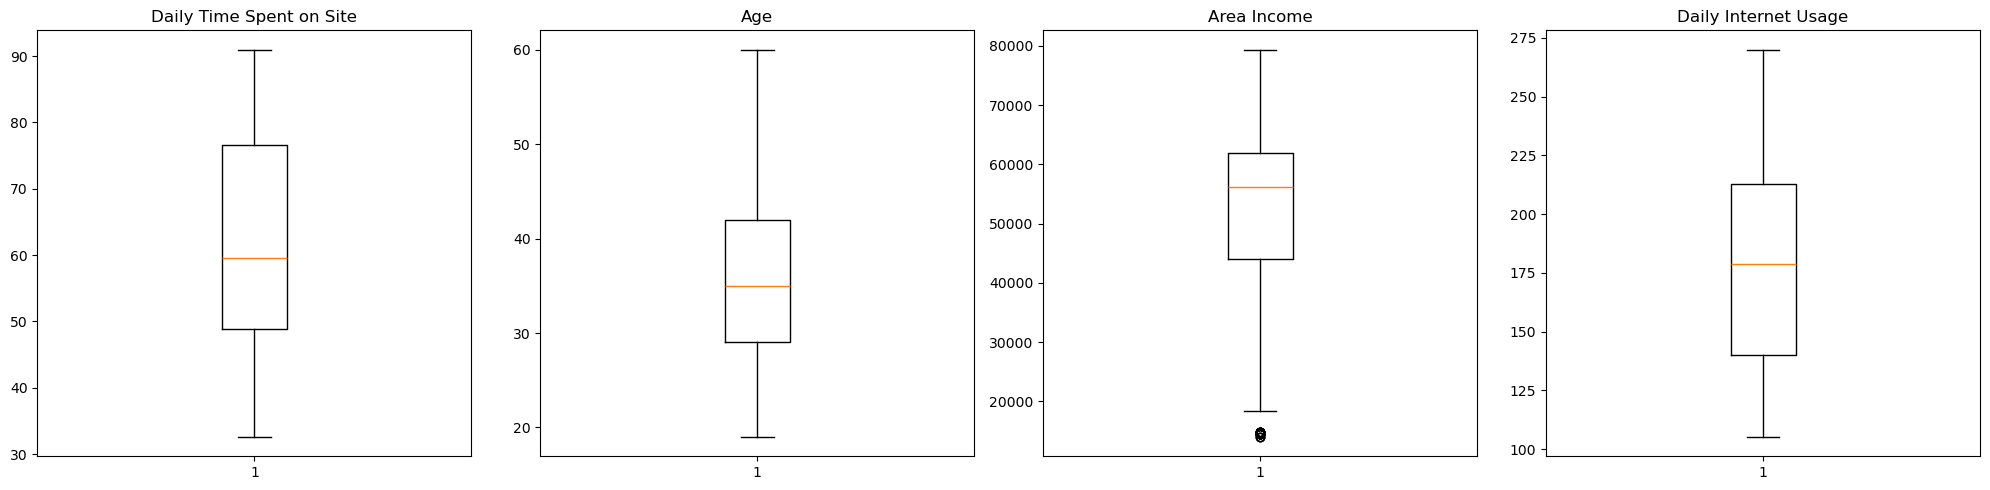

In [10]:
numerical_cols = df.select_dtypes(include = 'number').columns[:-1]

fig, axes = plt.subplots(1, len(numerical_cols), figsize = (20, 5))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [11]:
# extract time-connected features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday 
df['month'] = df['Timestamp'].dt.month

label_encoders = {}
for col in df.select_dtypes(include = 'object'):
    df[col] = df[col].str.title().str.strip()
    le = LabelEncoder()
    df[col + '_label'] = le.fit_transform(df[col])
    label_encoders[col] = le
    

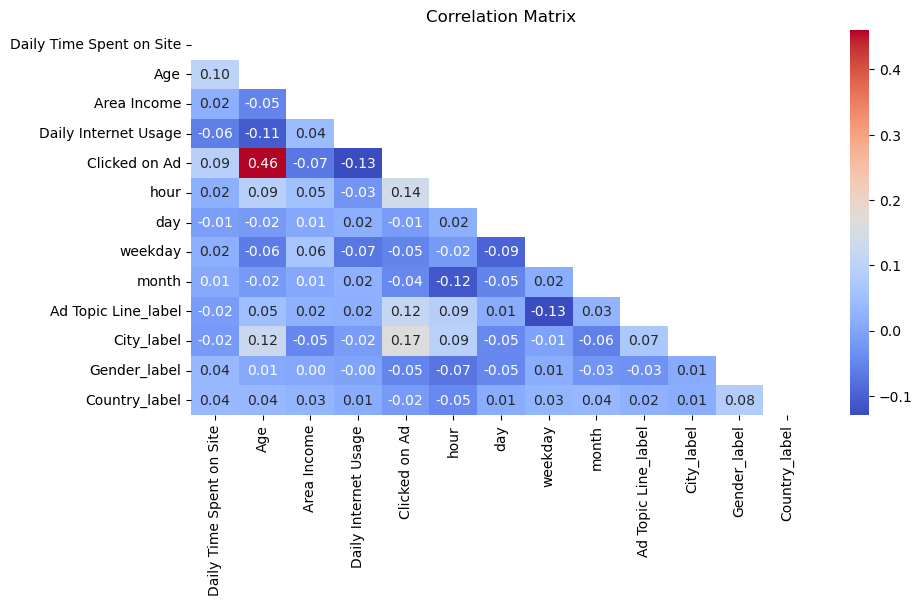

In [12]:
correlation_matrix = df[df.select_dtypes(include = 'number').columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (10, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', mask = mask)
plt.title('Correlation Matrix') 
plt.show()

Age is the only one labeled with red. If in the test part the model seems overfitted, we could considering about deleting "Age".